**Luhang Sun & Roujia Zhong**

Fall 2020

CS343: Neural Networks

Project 4: Transfer Learning

**Submission reminder:** Did you answer all 12 questions?

In [6]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=3)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Task 3: DeepDream

You will make use of a pre-trained neural network (`VGG16`) to implement the **DeepDream (gradient ascent)** algorithm using TensorFlow 2. The algorithm projects the receptive fields of specific filters and/or layers onto the input image to create some trippy effects! A neat side effect of this process is that you can visualize how learned weights at different levels of the network interact with parts of the input image.

This task will expose you to TensorFlow's low level API that operates on image data in the Tensor data structure.

### Overview

1. Load in the VGG16 pre-trained network without the output layer.
1. Make a `keras` "Model" that allows us to reference the activation (output) of each VGG16 network layer.
1. Select the types of layers (e.g. conv, pooling, etc) that we want to use to run Deep Dream on to influence the input image.
1. Pass image through the network, compute the netAct values and gradient at the selected layers.
1. Do gradient ascent where we add a proportion of the gradient from a network layer back into the image for some number of iterations.

### 3a. Import mountain image

Run the below code to load in the mountain test image at 224 x 224 resolution (1x). This matches the resolution of images on which VGG16 was trained. 

*If you have a more powerful machine (or are willing to wait longer for prettier pictures), you can use the provided 2x or 3x images.*

Image size is (224, 224, 3)


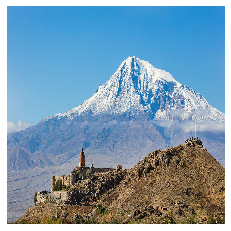

Image min/max is: 0.0/1.0. It should be 0.0/1.0


In [2]:
img_filename = os.path.join('data', 'mountain_1x.png')
img = plt.imread(img_filename)
print(f'Image size is {img.shape}')
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

print(f'Image min/max is: {img.min()}/{img.max()}. It should be 0.0/1.0')

### 3b. Load in pre-trained VGG16 network.

Like what you did on the Transfer Learning Task, load in the [pre-trained VGG16 network]((https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16)) and set it to a variable called `vgg`.

Don't load/include the trained output layer.

If you call the `summary()` method on the network object, you should see the following at the bottom:

    Total params: 14,714,688
    Trainable params: 14,714,688
    Non-trainable params: 0

In [3]:
vgg = tf.keras.applications.VGG16(
    include_top=False, weights='imagenet', input_tensor=None, input_shape=None,
    pooling=None, classes=1000, classifier_activation='softmax'
)

In [4]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

### 3c. Create a list of `VGG16` network layers whose activation we want to sample

Run the following code that define the layers and/or specific neurons whose activity we will amplify by adding their gradient back into the input image.

Then write code to create a Python list that stores the INDICES of **max pooling layers** from the big list of all network layer strings. The indices for the pooling layers should be `[3, 6, 10, 14, 18]`. Don't hard-code this because you will need to change the layer type later — come up with a robust, programatic approach to extracting the indices.

In [5]:
# Create a list of all NON-INPUT layer names in the VGG16 network.
# These are the strings in the left-most column in the `summary()` view above.
all_layer_names = [layer.name for layer in vgg.layers]

# Make a list of references to each layer's netAct values (`output` fields) of every NON-INPUT LEVEL layer object.
# Reference here is important bc we haven't showed the network the mountain image yet! But once we do,
# `layers` will point to the resulting activations.
layers = [vgg.get_layer(name).output for name in all_layer_names]

In [6]:
selectedLayerInds = []
for i in range(len(all_layer_names)):
    if "pool" in all_layer_names[i]:
        selectedLayerInds.append(i)

selectedLayerNames = np.array(all_layer_names)[selectedLayerInds].tolist()

print('Max pooling layer names:\n', selectedLayerNames)
print('Max pooling layer indices:\n', selectedLayerInds)

Max pooling layer names:
 ['block1_pool', 'block2_pool', 'block3_pool', 'block4_pool', 'block5_pool']
Max pooling layer indices:
 [3, 6, 10, 14, 18]


### 3d. DeepDream iteration step 1: Compute the network activation to the input image


Below, you will pass the input image to the network to compute the forward pass activations (netAct) in each network layer.

#### Todo

- Make a new `tf.Variable` object from the numpy image data `img`. Recall, this is necessary to track its gradients throughout the network.
- Create a new `DeepDream` object, passing in all the necessary parameters for all the pooling layers in the network.
- Implement then test `forward` in `DeepDream`.

#### Test `forward`

1. Run `forward()` on the 1x mountain image with `filter_inds=[55, 56]`. If everything works, you should get the following mean netAct values from each respective the Max Pooling layer:<br/>`[2.79232359, 3.4536202, 1.45324695, 0.214050353, 0.716764152]`

2. Run `forward()` on the 1x mountain image with `filter_inds=[]`. If everything works, you should get the following mean netAct values from each respective the pooling layer:<br/>`[2.60964131, 4.14118624, 4.03892231, 0.559926212, 0.152407467]`


In [7]:
from deep_dream import *

In [8]:
# Make a keras 'Model' object that will allow us to pass in the input image
# and get the activations (outputs) at each network level
tf_net = tf.keras.Model(inputs=layers[0], outputs=layers)
img_tf = tf.Variable(img)

# Test 1
dd1 = DeepDream(tf_net, selectedLayerInds, all_layer_names, filter_inds=[55,56])
netAct1 = dd1.forward(img_tf, verbose=True)
print("test 1 finish ---------------------------")

# Test 2
dd2 = DeepDream(tf_net, selectedLayerInds, all_layer_names)
netAct2 = dd2.forward(img_tf, verbose=True)


proccessing selective mean on ['block1_pool', 'block2_pool', 'block3_pool', 'block4_pool', 'block5_pool']: 2.792323589324951
proccessing selective mean on ['block1_pool', 'block2_pool', 'block3_pool', 'block4_pool', 'block5_pool']: 3.453620195388794
proccessing selective mean on ['block1_pool', 'block2_pool', 'block3_pool', 'block4_pool', 'block5_pool']: 1.4532469511032104
proccessing selective mean on ['block1_pool', 'block2_pool', 'block3_pool', 'block4_pool', 'block5_pool']: 0.21405035257339478
proccessing selective mean on ['block1_pool', 'block2_pool', 'block3_pool', 'block4_pool', 'block5_pool']: 0.7167641520500183
test 1 finish ---------------------------
proccessing non-selective mean on ['block1_pool', 'block2_pool', 'block3_pool', 'block4_pool', 'block5_pool']: 2.6096413135528564
proccessing non-selective mean on ['block1_pool', 'block2_pool', 'block3_pool', 'block4_pool', 'block5_pool']: 4.141186237335205
proccessing non-selective mean on ['block1_pool', 'block2_pool', 'bloc

### 3e. Questions

**Question 7:** Describe briefly in your own words the meaning of each of the single float values returned by `forward` (i.e. what does each number in the test code results represent)? You don't need to give 5 answers, just what does the $i^{th}$ one mean?

**Answer 7**: It is the influence of each selected layer onto the image, customized by the neurons that we selected. 

### 3f. DeepDream iteration step 2: Compute normalized gradients of each layer with respect to input image

Here you will compute the gradient of each selected layer with respect to the input image. Use the gradient tape so that TensorFlow automatically will manage the gradients as you perform a forward pass on the image. Collect these recorded gradients and normalize them.

#### Todo

Implement `image_gradient` in `deep_dream.py`.

The gradients should be standardized: $$\hat{g} = \frac{g - \mu}{ \sigma +\epsilon}$$ where

- $g$ is the current gradient tensor
- $\mu$ is the mean of the layer gradient (computed over all units in the layer)
- $\sigma$ is the standard deviation of the layer gradient (computed over all units in the layer)
- $\epsilon$ is a small number to prevent division by 0 (e.g. `1e-8`) 

#### Test `image_gradient`

The below test code should result in the following for the 1x mountain image with all Max Pooling layers:

    [<tf.Tensor: shape=(), dtype=float32, numpy=-0.0015869141>,
     <tf.Tensor: shape=(), dtype=float32, numpy=-0.0006713867>,
     <tf.Tensor: shape=(), dtype=float32, numpy=0.00033569336>,
     <tf.Tensor: shape=(), dtype=float32, numpy=0.00021362305>,
     <tf.Tensor: shape=(), dtype=float32, numpy=-0.0014877319>]

In [9]:
img_grads = dd2.image_gradient(img_tf, verbose=False)
[tf.reduce_sum(grad) for grad in img_grads]

[<tf.Tensor: shape=(), dtype=float32, numpy=-0.0015869141>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.0006713867>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.00033569336>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.00021362305>,
 <tf.Tensor: shape=(), dtype=float32, numpy=-0.0014877319>]

### 3g. Iterate DeepDream for multiple iterations: The gradient ascent algorithm

Bring the `forward` and `image_gradient` step together to iteratively perform DeepDream on the image. The result is a surreal, trippy, dreamy effect that merges the neural and image representations.

#### Todo

Implement the following methods in `deep_dream.py`:

- `gradient_ascent`. The updating process follows the equation $$x_{t+1} = x_t + \Delta_i \times s$$ where $x$ is the image tensor (*there is a t subscript because the image is changing as the neural signals affect it over time*), $\Delta_i$ is the gradient for the $i^{th}$ selected network layer, and $s$ is the step size.
- `tf2array`. We need this to visualize the results of DeepDream!

#### Test `gradient_ascent`

In the cell below, write code to test DeepDream/`gradient_ascent`. Overall, the test code that you write should resemble what you wrote in Task 3d. It should do the following:
- Wrap the mountain image as a `tf.Variable` type.
- Create a new `DeepDream` object and configure it so that only the last max pooling layer can affect the input image.
- Run gradient ascent on the image for 20 iterations.


It may be helpful to print (if verbose) the current iteration of gradient ascent to get a sense of progress.

#### Visualize the DeepDream image using `tf2array`

Now that you have your DeepDream image created through gradient ascent, call `tf2array` to convert it into an image that can visualized with matplotlib. Do this with `plt.imshow`.

In [10]:
selectedLayerInds_test = len(all_layer_names) - 1
dd_test = DeepDream(tf_net, selectedLayerInds_test, all_layer_names)
img_updated = dd_test.gradient_ascent(img_tf, n_iter=50, verbose=True)

proccessing non-selective mean on block5_pool: 0.1524074673652649
proccessing non-selective mean on block5_pool: 0.2048436403274536
proccessing non-selective mean on block5_pool: 0.252848744392395
proccessing non-selective mean on block5_pool: 0.2915390431880951
proccessing non-selective mean on block5_pool: 0.32370737195014954
proccessing non-selective mean on block5_pool: 0.3487864136695862
proccessing non-selective mean on block5_pool: 0.37668365240097046
proccessing non-selective mean on block5_pool: 0.40564775466918945
proccessing non-selective mean on block5_pool: 0.42777788639068604
proccessing non-selective mean on block5_pool: 0.4543246030807495
proccessing non-selective mean on block5_pool: 0.47838303446769714
proccessing non-selective mean on block5_pool: 0.5028694868087769
proccessing non-selective mean on block5_pool: 0.5266537070274353
proccessing non-selective mean on block5_pool: 0.5495912432670593
proccessing non-selective mean on block5_pool: 0.5754809379577637
procce

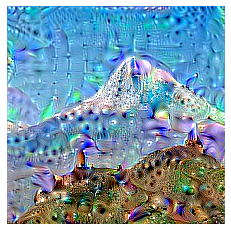

In [11]:
img_adj = dd_test.tf2array(img_updated)
plt.imshow(img_adj)
plt.xticks([])
plt.yticks([])
plt.show()

### 3h. Refine DeepDream by running it with multiple image scales

While the existing algorithm results in some cool effects, some small additional work can make the DeepDream images look a lot better.

Implement `gradient_ascent_multiscale` in `deep_dream.py`. In this version, apply the gradient ascent algorithm on the image over multiple runs. Each time you finish a run, scale (enlarge) the image so that you run gradient ascent again on the larger version of image.

Since this is effectively repeating `gradient_ascent` a set number of times, it will take longer to finish computing. If `verbose` is turned on, add print outs showing "run-level" progress.

#### Test `gradient_ascent_multiscale`

Copy-and-paste your test code that you wrote for Task 3g, but now run `gradient_ascent_multiscale` instead of `gradient_ascent`. Run it with default parameters for now. Apply `tf2array` and visualize the resulting image using matplotlib.

In [48]:
tf_net = tf.keras.Model(inputs=layers[0], outputs=layers)
selectedLayerInds_test = len(all_layer_names) - 1
dd_test2 = DeepDream(tf_net, selectedLayerInds_test, all_layer_names)
img_updated = dd_test2.gradient_ascent_multiscale(img_tf, n_iter=20, verbose=True)

proccessing non-selective mean on block5_pool: 0.3971171975135803
proccessing non-selective mean on block5_pool: 0.4318366050720215
proccessing non-selective mean on block5_pool: 0.4606402516365051
proccessing non-selective mean on block5_pool: 0.48854750394821167
proccessing non-selective mean on block5_pool: 0.5205041766166687
proccessing non-selective mean on block5_pool: 0.5505086779594421
proccessing non-selective mean on block5_pool: 0.5754246711730957
proccessing non-selective mean on block5_pool: 0.6034485101699829
proccessing non-selective mean on block5_pool: 0.6281129717826843
proccessing non-selective mean on block5_pool: 0.657126784324646
proccessing non-selective mean on block5_pool: 0.6816836595535278
proccessing non-selective mean on block5_pool: 0.707118034362793
proccessing non-selective mean on block5_pool: 0.7281455397605896
proccessing non-selective mean on block5_pool: 0.7530017495155334
proccessing non-selective mean on block5_pool: 0.7764014601707458
proccessing

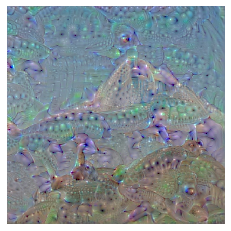

In [50]:
img_adj = dd_test.tf2array(img_updated)
plt.imshow(img_adj)
plt.xticks([])
plt.yticks([])
plt.show()

### 3i. Questions

Generate several DeepDream images to accompany each of your written answers to the following questions. You can include them inline with your answers below.

**Question 8:** Give at least two reasons why the multi-scale version tends to produce better visualizations. Hint: think about the filter receptive fields involved in the process.

**Question 9**: What differences do you notice if you only use earlier/later network layers to do the deep dream process?

**Question 10**: Describe what you notice when you let all max pooling layers contribute to the deep dream image.

**Question 11**: What happens when you pick specific filters to project rather than average all unit activation in a layer?

**Question 12**: Do you notice any difference when selecting a different layer type to do the Deep Dream process (other than max pooling)?

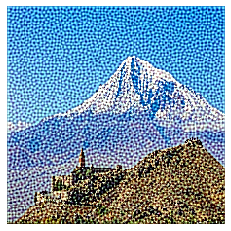

In [14]:
# 9: use only the earlier layer (the first max-pooling layer)
img_tf = tf.Variable(img)
dd9 = DeepDream(tf_net, 3, all_layer_names)
img_updated9 = dd9.gradient_ascent(img_tf, n_iter=20, verbose=False)
img_adj9 = dd9.tf2array(img_updated9)
plt.imshow(img_adj9)
plt.xticks([])
plt.yticks([])
plt.show()

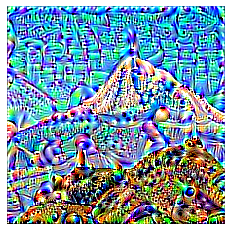

In [15]:
# 10: use all the max-pooling layer
img_tf = tf.Variable(img)
dd10 = DeepDream(tf_net, selectedLayerInds, all_layer_names)
img_updated10 = dd10.gradient_ascent(img_tf, n_iter=20, verbose=False)
img_adj10 = dd10.tf2array(img_updated10)
plt.imshow(img_adj10)
plt.xticks([])
plt.yticks([])
plt.show()

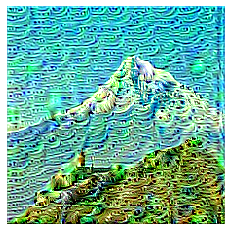

In [59]:
# 11: [55, 56] as specific filter to project (still use the last max-pooling layer only)
img_tf = tf.Variable(img)
dd11 = DeepDream(tf_net, selectedLayerInds, all_layer_names, [55, 56, 3])
img_updated11 = dd11.gradient_ascent(img_tf, n_iter=20, verbose=False)
img_adj11 = dd11.tf2array(img_updated11)
plt.imshow(img_adj11)
plt.xticks([])
plt.yticks([])
plt.show()

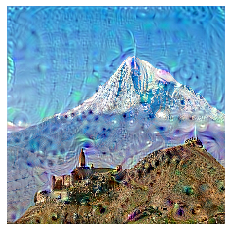

In [54]:
# 12: different layer type other than max pooling (the last conv layer)
img_tf = tf.Variable(img)
selectedLayerInds_12 = len(all_layer_names) - 2
dd12 = DeepDream(tf_net, selectedLayerInds_12, all_layer_names)
img_updated12 = dd12.gradient_ascent(img_tf, n_iter=20, verbose=False)
img_adj12 = dd12.tf2array(img_updated12)
plt.imshow(img_adj12)
plt.xticks([])
plt.yticks([])
plt.show()

**Answer 8:** 1) the resolution of the image is larger so it looks better. 2) The receptive field is repeatively modified for 4x more times than simple gradient ascent, so the influence is larger. 

**Answer 9**: The earlier network (the first max-pooling layer) is focused on RGB noise/edges of the image while the last max-pooling layer influences the image based on its patterns. 

**Answer 10**: using all the max-pooling layer generated a cartoon-like output, whose edges are hard and solid, and the contrast of the image is very high. This is probably because the image was influenced on RGD noise, edges, small and large patterns, etc. - basically all the aspects of its composition. We liked the effect though :)

**Answer 11**: Projecting only selected filter indices would add a universal pattern across the image

**Answer 12**: Here I used the last convolution layer, which did not project animal-like patterns to the image but still produced some curly patterns. I think non maxpooling layers are less sensitive to a specific pattern because they are not only extracting the important information from the input, but instead average out the effects. 

## Extensions

### 1. Run Deep Dream on your own images. Make some interesting effects.

Note that you will likely have to convert images from uint8 to float32 and normalize to the [0, 1] range.

You will probably want to resize your images as part of the preprocessing to keep simulation time reasonable.

Play with the number of gradient ascent iterations.

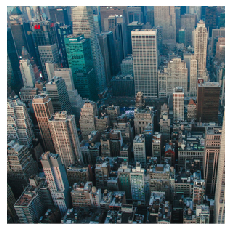

In [20]:
# I used a picture that I took in NYC in 2019 
# resized it 
from PIL import Image
nyc = Image.open("data/nyc.png")
nyc = nyc.resize((300, 300), Image.ANTIALIAS)
nyc = np.asarray(nyc, dtype=np.float32)
nyc = (nyc - nyc.min())/(nyc.max()-nyc.min())
nyc = np.delete(nyc, 3, axis=2)
plt.imshow(nyc)
plt.xticks([])
plt.yticks([])
plt.show()

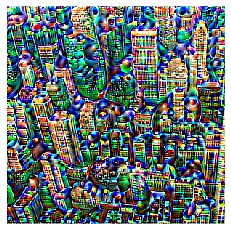

In [109]:
# using all the max-pooling layers - it creates a kinda cool cartoon effect on the image and animal-matching patterns
nyc_tf = tf.Variable(nyc)
dd_ext1 = DeepDream(tf_net, selectedLayerInds, all_layer_names)
nyc_updated_ext1 = dd_ext1.gradient_ascent(nyc_tf, n_iter=20, verbose=False)
nyc_adj_ext1 = dd_ext1.tf2array(nyc_updated_ext1)
plt.imshow(nyc_adj_ext1)
plt.xticks([])
plt.yticks([])
plt.show()

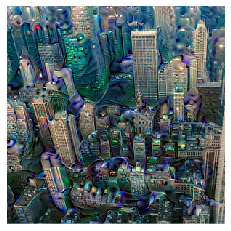

In [113]:
# Using the last max pooling layer - effects on smaller details
nyc_tf = tf.Variable(nyc)
dd_ext2 = DeepDream(tf_net, selectedLayerInds[-1], all_layer_names)
nyc_updated_ext2 = dd_ext2.gradient_ascent(nyc_tf, n_iter=20)
nyc_adj_ext2 = dd_ext2.tf2array(nyc_updated_ext2)
plt.imshow(nyc_adj_ext2)
plt.xticks([])
plt.yticks([])
plt.show()

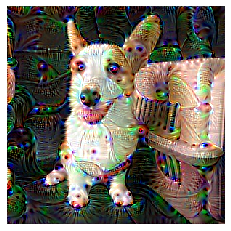

In [120]:
# This is Roujia's little puppy that she just got 4 months ago :) 
dog1 = Image.open("data/dog1.png")
dog1 = dog1.resize((300, 300), Image.ANTIALIAS)
dog1 = np.asarray(dog1, dtype=np.float32)
dog1 = (dog1 - dog1.min())/(dog1.max()-dog1.min())
dog1 = np.delete(dog1, 3, axis=2)

dog1_tf = tf.Variable(dog1)
dd_ext2 = DeepDream(tf_net, selectedLayerInds[-2], all_layer_names)
dog1_updated_ext2 = dd_ext2.gradient_ascent(dog1_tf, n_iter=30)
dog1_adj_ext2 = dd_ext2.tf2array(dog1_updated_ext2)
plt.imshow(dog1_adj_ext2)
plt.xticks([])
plt.yticks([])
plt.show()

### 2. Research other pretrained networks in tensorflow and run DeepDream on their layers/filters.

We used the InceptionV2 network, which is a much larger network. The official documentation said our layers of interest are those where the convolutions are concatenated. There are 11 of these layers in InceptionV3, named 'mixed0' though 'mixed10'. Through our testing, InceptionV2 seems to be more efficient(quicker) than the vgg network, although it increased in size of the network. We were able to compute the output of a (1000x1000) image in a reasonable amount of time. Its official documentation also said that it works the best for complex inputs because of its efficient architecture compared to InceptionV1. 

In [18]:
inception = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', input_tensor=None, input_shape=None,
    pooling=None, classes=1000, classifier_activation='softmax')
inception.summary()

][0]             
__________________________________________________________________________________________________
conv2d_163 (Conv2D)             (None, None, None, 1 147456      average_pooling2d_15[0][0]       
__________________________________________________________________________________________________
batch_normalization_154 (BatchN (None, None, None, 1 576         conv2d_154[0][0]                 
__________________________________________________________________________________________________
batch_normalization_157 (BatchN (None, None, None, 1 576         conv2d_157[0][0]                 
__________________________________________________________________________________________________
batch_normalization_162 (BatchN (None, None, None, 1 576         conv2d_162[0][0]                 
__________________________________________________________________________________________________
batch_normalization_163 (BatchN (None, None, None, 1 576         conv2d_163[0][0]          

In [38]:
# set up the inception DD network
all_layer_names_new = [layer.name for layer in inception.layers]
layers_new = [inception.get_layer(name).output for name in all_layer_names_new]

selectedLayerInds = []
for i in range(len(all_layer_names_new)):
    if "mixed" in all_layer_names_new[i]:
        selectedLayerInds.append(i)
selectedLayerNames = np.array(all_layer_names_new)[selectedLayerInds].tolist()

dream_model = tf.keras.Model(inputs=layers_new[0], outputs=layers_new)

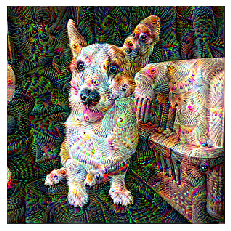

In [46]:
ddi = DeepDream(dream_model, selectedLayerInds[3:6], all_layer_names_new)
dog1 = Image.open("data/dog1.png")
dog1 = dog1.resize((300, 300), Image.ANTIALIAS)
dog1 = np.asarray(dog1, dtype=np.float32)
dog1 = (dog1 - dog1.min())/(dog1.max()-dog1.min())
dog1 = np.delete(dog1, 3, axis=2)

dog1_tf = tf.Variable(dog1)
dog1_updated_ext2 = ddi.gradient_ascent(dog1_tf, n_iter=50)
dog1_adj_ext2 = ddi.tf2array(dog1_updated_ext2)
plt.imshow(dog1_adj_ext2)
plt.xticks([])
plt.yticks([])
plt.show()

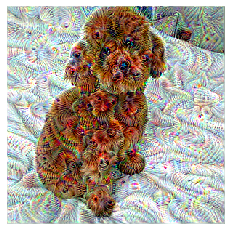

In [45]:
# Luhang's dog :)
dream_model_2 = tf.keras.Model(inputs=layers_new[0], outputs=layers_new)
ddi_2 = DeepDream(dream_model_2, selectedLayerInds[3:6], all_layer_names_new)

# preprocess the image
dog2 = Image.open("data/dog2.png")
dog2 = dog2.resize((300, 300), Image.ANTIALIAS)
dog2 = np.asarray(dog2, dtype=np.float32)
dog2 = (dog2 - dog2.min())/(dog2.max()-dog2.min())
dog2 = np.delete(dog2, 3, axis=2)

dog2_tf = tf.Variable(dog2)
dog2_updated_ext2 = ddi_2.gradient_ascent(dog2_tf, n_iter=30)
dog2_adj_ext2 = ddi_2.tf2array(dog2_updated_ext2)
plt.imshow(dog2_adj_ext2)
plt.xticks([])
plt.yticks([])
plt.show()

It creates a different texture on the image from vgg. These two doggies images are affected by the network differently and we found out to produce a better quality "drea" image, the backgroud of the image should preferably be light colors, where the patterns could easily be matched. For curiosity, we also wanted to explore what the max-pooling layer in this network does. 

[10, 17, 99, 247]


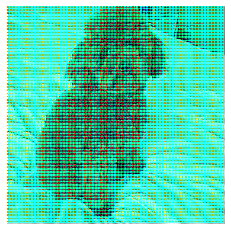

In [36]:
# what does max pooling do in the inception model?
selectedLayerInds = []
for i in range(len(all_layer_names_new)):
    if "max_pooling" in all_layer_names_new[i]:
        selectedLayerInds.append(i)
selectedLayerNames = np.array(all_layer_names_new)[selectedLayerInds].tolist()
print(selectedLayerInds)
dream_model_2 = tf.keras.Model(inputs=layers_new[0], outputs=layers_new)
ddi_2 = DeepDream(dream_model_2, [len(selectedLayerInds)-2, len(selectedLayerInds)-.delete(dog2, 3, axis=2)

dog2_tf = tf.Variable(dog2)
dog2_updated_ext2 = ddi_2.gradient_ascent(dog2_tf, n_iter=30)
dog2_adj_ext2 = ddi_2.tf2array(dog2_updated_ext2)
plt.imshow(dog2_adj_ext2)
plt.xticks([])
plt.yticks([])
plt.show()

The result shows that max-pooling does completely different thing on this network. Mix layers used previously are concatenated convolutions, which are the core of this model. 

### 3. Automate the visualization process for many filters and/or subsets of layers. Make grids of output images. Do you find patterns in any of the filters?

### 4. Transfer learning: What's the best test accuracy that you can achieve on the hot dog or not dataset? How did you do it?

### 5. Keras ConvNet4: Explore and analyze how different network architectures affect the STL-10 results.

We explored several different network architectures. The first network architecture we explored was adding an additional sigmoid dense layer to the network (3 Dense layer in total). The second network architecture we explored was adding another set of convolutional layer and max pooling layer as well as an additional softmax dense layer. The third network architecture was adding 2 softmax layers to the network. 

We first loaded in the STL-10 datasets and preprocess the data.

In [1]:
import load_stl10_dataset
import preprocess_data
import matplotlib.pyplot as plt

In [2]:
load_stl10_dataset.purge_cached_dataset()
# preprocess and create splits
x_train, y_train, x_test, y_test, x_val, y_val, x_dev, y_dev = preprocess_data.load_stl10(
    n_train_samps=4398, n_test_samps=400, n_valid_samps=200, n_dev_samps=2, scale_fact=3)

print ('Train data shape: ', x_train.shape)
print ('Train labels shape: ', y_train.shape)
print ('Test data shape: ', x_test.shape)
print ('Test labels shape: ', y_test.shape)
print ('Validation data shape: ', x_val.shape)
print ('Validation labels shape: ', y_val.shape)
print ('dev data shape: ', x_dev.shape)
print ('dev labels shape: ', y_dev.shape)

Images are: (5000, 96, 96, 3)
Labels are: (5000,)
Resizing 5000 images to 32x32...Done!
Saving Numpy arrays the images and labels to ./numpy...Done!
Train data shape:  (4398, 3, 32, 32)
Train labels shape:  (4398,)
Test data shape:  (400, 3, 32, 32)
Test labels shape:  (400,)
Validation data shape:  (200, 3, 32, 32)
Validation labels shape:  (200,)
dev data shape:  (2, 3, 32, 32)
dev labels shape:  (2,)


In [7]:
#reshape the data array so that the color channel is after the spatial dimensions
x_train = np.swapaxes(x_train, 1, 2)
x_train = np.swapaxes(x_train, 2, 3)
x_test = np.swapaxes(x_test, 1, 2)
x_test = np.swapaxes(x_test, 2, 3)
x_val = np.swapaxes(x_val, 1, 2)
x_val = np.swapaxes(x_val, 2, 3)

print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

(4398, 32, 32, 3)
(400, 32, 32, 3)
(200, 32, 32, 3)


### Architecture 1: 
The architecture of the network with an additional layer is: Convolution -> Max Pooling 2D -> Dense(relu) -> Dense(sigmoid) -> Dense(softmax).
To evaluate the effects on STL-10 results, we plotted the changes of accuracy and loss over training epochs. We also computed the maximum validation accuracy and minimum validation loss. 

In [8]:
#define the number of hidden units
H1 = 100 # num hidden units in L1 (1st hidden layer)
H2 = 100
C = 10

model = tf.keras.Sequential(
    [
        
        tf.keras.Input(shape = x_train.shape[1:]),
        tf.keras.layers.Conv2D(filters = 32, kernel_size = 7, padding = "same", activation = "relu"),
        tf.keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units = H1, activation = 'relu'),
        tf.keras.layers.Dense(units = H2, activation = 'sigmoid'),
        tf.keras.layers.Dense(units = C, activation = 'softmax'),
        
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        4736      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               819300    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 835,146
Trainable params: 835,146
Non-trainable params: 0
__________________________________________________

In [9]:
#compile the network
adam = tf.optimizers.Adam(lr = 1e-4)
model.compile(optimizer = adam, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
#sparse_categorical: classes are int-coded

hist = model.fit(x_train, y_train, batch_size = 100, epochs = 100, validation_data = (x_val, y_val))
print('done')

Epoch 1/100
44/44 [==============================] - 2s 54ms/step - loss: 2.2623 - accuracy: 0.1871 - val_loss: 2.1606 - val_accuracy: 0.2400
Epoch 2/100
44/44 [==============================] - 2s 50ms/step - loss: 2.0251 - accuracy: 0.2874 - val_loss: 2.0462 - val_accuracy: 0.2550
Epoch 3/100
44/44 [==============================] - 2s 53ms/step - loss: 1.8981 - accuracy: 0.3379 - val_loss: 1.9645 - val_accuracy: 0.2750
Epoch 4/100
44/44 [==============================] - 3s 61ms/step - loss: 1.8198 - accuracy: 0.3524 - val_loss: 1.9057 - val_accuracy: 0.2900
Epoch 5/100
44/44 [==============================] - 3s 57ms/step - loss: 1.7637 - accuracy: 0.3709 - val_loss: 1.8522 - val_accuracy: 0.3250
Epoch 6/100
44/44 [==============================] - 3s 59ms/step - loss: 1.7195 - accuracy: 0.3879 - val_loss: 1.8150 - val_accuracy: 0.3250
Epoch 7/100
44/44 [==============================] - 3s 59ms/step - loss: 1.6777 - accuracy: 0.4093 - val_loss: 1.7916 - val_accuracy: 0.3250
Epoch 

44/44 [==============================] - 3s 59ms/step - loss: 0.7899 - accuracy: 0.7704 - val_loss: 1.4411 - val_accuracy: 0.5050
Epoch 59/100
44/44 [==============================] - 3s 59ms/step - loss: 0.7740 - accuracy: 0.7747 - val_loss: 1.4240 - val_accuracy: 0.5050
Epoch 60/100
44/44 [==============================] - 3s 59ms/step - loss: 0.7636 - accuracy: 0.7767 - val_loss: 1.4358 - val_accuracy: 0.5000
Epoch 61/100
44/44 [==============================] - 3s 60ms/step - loss: 0.7542 - accuracy: 0.7851 - val_loss: 1.4238 - val_accuracy: 0.5100
Epoch 62/100
44/44 [==============================] - 3s 59ms/step - loss: 0.7422 - accuracy: 0.7867 - val_loss: 1.4366 - val_accuracy: 0.5100
Epoch 63/100
44/44 [==============================] - 3s 61ms/step - loss: 0.7333 - accuracy: 0.7988 - val_loss: 1.4326 - val_accuracy: 0.5050
Epoch 64/100
44/44 [==============================] - 3s 63ms/step - loss: 0.7157 - accuracy: 0.7972 - val_loss: 1.4289 - val_accuracy: 0.5100
Epoch 65/100

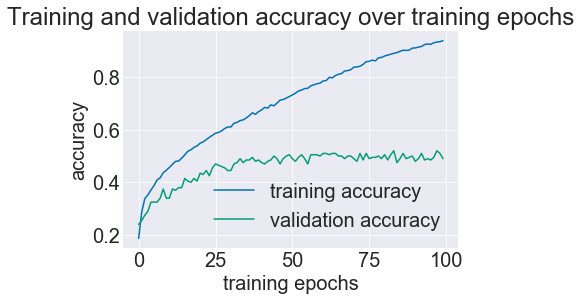

In [10]:
#training and validation accuracy over training epochs
plt.plot(hist.history['accuracy'], label = 'training accuracy')
plt.plot(hist.history['val_accuracy'], label = 'validation accuracy')
plt.legend()
plt.xlabel('training epochs')
plt.ylabel('accuracy')
plt.title('Training and validation accuracy over training epochs')
plt.show()

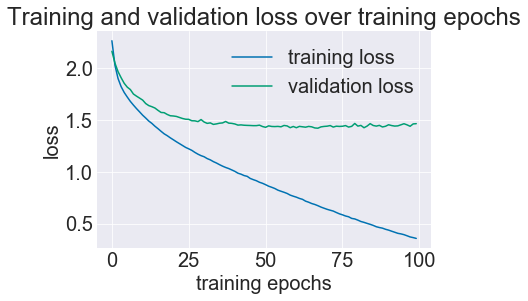

In [11]:
#training and validation loss over training epochs
plt.plot(hist.history['loss'], label = 'training loss')
plt.plot(hist.history['val_loss'], label = 'validation loss')
plt.legend()
plt.xlabel('training epochs')
plt.ylabel('loss')
plt.title('Training and validation loss over training epochs')
plt.show()

In [12]:
#print out the maximum validation accuracy
print('Maximum validation accuracy: ', np.max(hist.history['val_accuracy']))
#print out the minimum validation loss
print('Minimum validation loss: ', np.min(hist.history['val_loss']))

Maximum validation accuracy:  0.5199999809265137
Minimum validation loss:  1.419010877609253


### Effects of Architecture 1 on results: 
The analysis shown above shows that the best validation accuracy when the network has an additional sigmoid layer is 0.51999. And the best validation loss is 1.419. These results are very similar to the results of the network without the sigmoid layer. One difference we have noticed is that this network is not overfitting the data seriously in comparison to the network without the sigmoid layer.

### Architecture 2: 
Based on the network architecture we constructed above, we added another set of Conv2D and max pooling layers to the network. The architecture of the network with additional layers is: Convolution -> Max Pooling 2D -> Convolution -> Max Pooling 2D -> Dense(relu) -> Dense(sigmoid) -> Dense(softmax).

In [13]:
model = tf.keras.Sequential(
    [
        
        tf.keras.Input(shape = x_train.shape[1:]),
        tf.keras.layers.Conv2D(filters = 32, kernel_size = 7, padding = "same", activation = "relu"),
        tf.keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
        tf.keras.layers.Conv2D(filters = 32, kernel_size = 7, padding = "same", activation = "relu"),
        tf.keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units = H1, activation = 'relu'),
        tf.keras.layers.Dense(units = H2, activation = 'sigmoid'),
        tf.keras.layers.Dense(units = C, activation = 'softmax'),
        
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        4736      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        50208     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               204900    
_________________________________________________________________
dense_4 (Dense)              (None, 100)              

In [14]:
#compile the network
adam = tf.optimizers.Adam(lr = 1e-4)
model.compile(optimizer = adam, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
#sparse_categorical: classes are int-coded

hist = model.fit(x_train, y_train, batch_size = 100, epochs = 100, validation_data = (x_val, y_val))
print('done')

Epoch 1/100
44/44 [==============================] - 5s 113ms/step - loss: 2.4209 - accuracy: 0.1166 - val_loss: 2.2837 - val_accuracy: 0.1750
Epoch 2/100
44/44 [==============================] - 5s 119ms/step - loss: 2.1723 - accuracy: 0.2146 - val_loss: 2.1593 - val_accuracy: 0.2650
Epoch 3/100
44/44 [==============================] - 5s 117ms/step - loss: 2.0296 - accuracy: 0.2731 - val_loss: 2.0526 - val_accuracy: 0.2700
Epoch 4/100
44/44 [==============================] - 5s 115ms/step - loss: 1.9310 - accuracy: 0.3035 - val_loss: 1.9796 - val_accuracy: 0.2750
Epoch 5/100
44/44 [==============================] - 5s 118ms/step - loss: 1.8652 - accuracy: 0.3397 - val_loss: 1.9171 - val_accuracy: 0.3050
Epoch 6/100
44/44 [==============================] - 5s 123ms/step - loss: 1.8162 - accuracy: 0.3536 - val_loss: 1.8755 - val_accuracy: 0.3250
Epoch 7/100
44/44 [==============================] - 5s 121ms/step - loss: 1.7812 - accuracy: 0.3558 - val_loss: 1.8521 - val_accuracy: 0.3400

Epoch 58/100
44/44 [==============================] - 6s 138ms/step - loss: 1.1169 - accuracy: 0.6212 - val_loss: 1.4981 - val_accuracy: 0.4500
Epoch 59/100
44/44 [==============================] - 5s 121ms/step - loss: 1.1109 - accuracy: 0.6257 - val_loss: 1.4862 - val_accuracy: 0.4500
Epoch 60/100
44/44 [==============================] - 5s 117ms/step - loss: 1.1030 - accuracy: 0.6253 - val_loss: 1.5014 - val_accuracy: 0.4600
Epoch 61/100
44/44 [==============================] - 5s 120ms/step - loss: 1.0922 - accuracy: 0.6266 - val_loss: 1.4990 - val_accuracy: 0.4500
Epoch 62/100
44/44 [==============================] - 5s 120ms/step - loss: 1.0830 - accuracy: 0.6328 - val_loss: 1.4887 - val_accuracy: 0.4500
Epoch 63/100
44/44 [==============================] - 5s 114ms/step - loss: 1.0758 - accuracy: 0.6385 - val_loss: 1.4812 - val_accuracy: 0.4700
Epoch 64/100
44/44 [==============================] - 5s 125ms/step - loss: 1.0650 - accuracy: 0.6414 - val_loss: 1.4726 - val_accuracy:

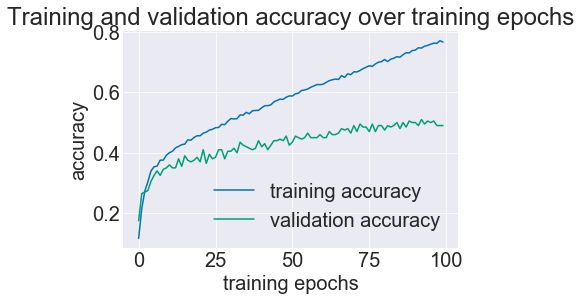

In [15]:
#training and validation accuracy over training epochs
plt.plot(hist.history['accuracy'], label = 'training accuracy')
plt.plot(hist.history['val_accuracy'], label = 'validation accuracy')
plt.legend()
plt.xlabel('training epochs')
plt.ylabel('accuracy')
plt.title('Training and validation accuracy over training epochs')
plt.show()

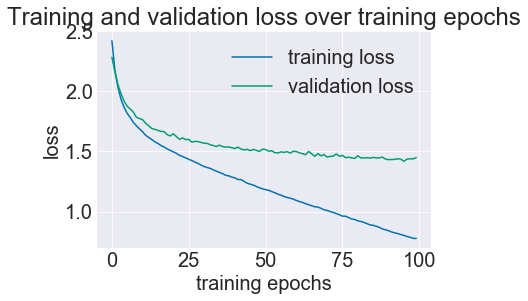

In [16]:
#training and validation loss over training epochs
plt.plot(hist.history['loss'], label = 'training loss')
plt.plot(hist.history['val_loss'], label = 'validation loss')
plt.legend()
plt.xlabel('training epochs')
plt.ylabel('loss')
plt.title('Training and validation loss over training epochs')
plt.show()

In [17]:
#print out the maximum validation accuracy
print('Maximum validation accuracy: ', np.max(hist.history['val_accuracy']))
#print out the minimum validation loss
print('Minimum validation loss: ', np.min(hist.history['val_loss']))

Maximum validation accuracy:  0.5099999904632568
Minimum validation loss:  1.4185634851455688


### Effects of Architecture 2 on results: 
The best validation accuracy and the best validation loss are similar to the results of the architecture 1. In addition, we realized that architecture 2 does not overfit the data severely. It performs better than the network architecture we used for task 1. 

### Architecture 3:
We wanted to explore the effects on results when there is an additional softmax layer based on the architecture 2. The architecture of the network with additional layers is: Convolution -> Max Pooling 2D -> Convolution -> Max Pooling 2D -> Dense(relu) -> Dense(sigmoid) -> Dense(softmax) -> Dense(softmax).

In [18]:
model = tf.keras.Sequential(
    [
        
        tf.keras.Input(shape = x_train.shape[1:]),
        tf.keras.layers.Conv2D(filters = 32, kernel_size = 7, padding = "same", activation = "relu"),
        tf.keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
        tf.keras.layers.Conv2D(filters = 32, kernel_size = 7, padding = "same", activation = "relu"),
        tf.keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units = H1, activation = 'relu'),
        tf.keras.layers.Dense(units = H2, activation = 'sigmoid'),
        tf.keras.layers.Dense(units = H2, activation = 'softmax'),
        tf.keras.layers.Dense(units = C, activation = 'softmax'),
        
    ]
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 32, 32, 32)        4736      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 32)        50208     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               204900    
_________________________________________________________________
dense_7 (Dense)              (None, 100)              

In [19]:
#compile the network
adam = tf.optimizers.Adam(lr = 1e-4)
model.compile(optimizer = adam, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
#sparse_categorical: classes are int-coded

hist = model.fit(x_train, y_train, batch_size = 100, epochs = 100, validation_data = (x_val, y_val))
print('done')

Epoch 1/100
44/44 [==============================] - 5s 124ms/step - loss: 2.3023 - accuracy: 0.1121 - val_loss: 2.3021 - val_accuracy: 0.1200
Epoch 2/100
44/44 [==============================] - 5s 119ms/step - loss: 2.2959 - accuracy: 0.1928 - val_loss: 2.2902 - val_accuracy: 0.1700
Epoch 3/100
44/44 [==============================] - 6s 126ms/step - loss: 2.2770 - accuracy: 0.1921 - val_loss: 2.2761 - val_accuracy: 0.1700
Epoch 4/100
44/44 [==============================] - 5s 120ms/step - loss: 2.2621 - accuracy: 0.1844 - val_loss: 2.2618 - val_accuracy: 0.1750
Epoch 5/100
44/44 [==============================] - 6s 127ms/step - loss: 2.2480 - accuracy: 0.1814 - val_loss: 2.2469 - val_accuracy: 0.1750
Epoch 6/100
44/44 [==============================] - 6s 126ms/step - loss: 2.2323 - accuracy: 0.1799 - val_loss: 2.2347 - val_accuracy: 0.1550
Epoch 7/100
44/44 [==============================] - 5s 116ms/step - loss: 2.2229 - accuracy: 0.1771 - val_loss: 2.2247 - val_accuracy: 0.1600

Epoch 58/100
44/44 [==============================] - 6s 130ms/step - loss: 2.0397 - accuracy: 0.2499 - val_loss: 2.0459 - val_accuracy: 0.2150
Epoch 59/100
44/44 [==============================] - 6s 127ms/step - loss: 2.0384 - accuracy: 0.2501 - val_loss: 2.0517 - val_accuracy: 0.2150
Epoch 60/100
44/44 [==============================] - 6s 125ms/step - loss: 2.0371 - accuracy: 0.2481 - val_loss: 2.0390 - val_accuracy: 0.2200
Epoch 61/100
44/44 [==============================] - 6s 134ms/step - loss: 2.0333 - accuracy: 0.2519 - val_loss: 2.0373 - val_accuracy: 0.2150
Epoch 62/100
44/44 [==============================] - 6s 137ms/step - loss: 2.0296 - accuracy: 0.2533 - val_loss: 2.0429 - val_accuracy: 0.2200
Epoch 63/100
44/44 [==============================] - 6s 137ms/step - loss: 2.0283 - accuracy: 0.2535 - val_loss: 2.0379 - val_accuracy: 0.2200
Epoch 64/100
44/44 [==============================] - 6s 131ms/step - loss: 2.0247 - accuracy: 0.2526 - val_loss: 2.0286 - val_accuracy:

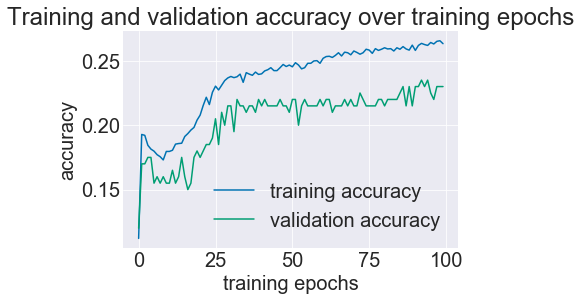

In [20]:
#training and validation accuracy over training epochs
plt.plot(hist.history['accuracy'], label = 'training accuracy')
plt.plot(hist.history['val_accuracy'], label = 'validation accuracy')
plt.legend()
plt.xlabel('training epochs')
plt.ylabel('accuracy')
plt.title('Training and validation accuracy over training epochs')
plt.show()

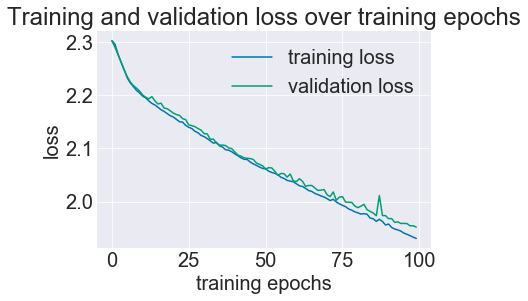

In [21]:
#training and validation loss over training epochs
plt.plot(hist.history['loss'], label = 'training loss')
plt.plot(hist.history['val_loss'], label = 'validation loss')
plt.legend()
plt.xlabel('training epochs')
plt.ylabel('loss')
plt.title('Training and validation loss over training epochs')
plt.show()

In [22]:
#print out the maximum validation accuracy
print('Maximum validation accuracy: ', np.max(hist.history['val_accuracy']))
#print out the minimum validation loss
print('Minimum validation loss: ', np.min(hist.history['val_loss']))

Maximum validation accuracy:  0.23499999940395355
Minimum validation loss:  1.951912522315979


### Effects of Architecture 3 on results: 
The results above show that the best validation accuracy and best validation loss are much lower than any of the previous models. The best validation accuracy is 0.23 and the best validation loss is 1.95.

### Architecture 4: 
The architecture of the network with additional layers is: Convolution -> Max Pooling 2D -> Convolution -> Max Pooling 2D -> Convolution -> Max Pooling 2D -> Dense(relu) -> Dense(sigmoid) -> Dense(softmax).

In [23]:
model = tf.keras.Sequential(
    [
        
        tf.keras.Input(shape = x_train.shape[1:]),
        tf.keras.layers.Conv2D(filters = 32, kernel_size = 7, padding = "same", activation = "relu"),
        tf.keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
        tf.keras.layers.Conv2D(filters = 32, kernel_size = 7, padding = "same", activation = "relu"),
        tf.keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
        tf.keras.layers.Conv2D(filters = 32, kernel_size = 7, padding = "same", activation = "relu"),
        tf.keras.layers.MaxPooling2D(pool_size = 2, strides = 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units = H1, activation = 'relu'),
        tf.keras.layers.Dense(units = H2, activation = 'sigmoid'),
        tf.keras.layers.Dense(units = H2, activation = 'softmax'),
        tf.keras.layers.Dense(units = C, activation = 'softmax'),
        
    ]
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 32)        4736      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 32)        50208     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 32)          50208     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)              

In [24]:
#compile the network
adam = tf.optimizers.Adam(lr = 1e-4)
model.compile(optimizer = adam, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
#sparse_categorical: classes are int-coded

hist = model.fit(x_train, y_train, batch_size = 100, epochs = 100, validation_data = (x_val, y_val))
print('done')

Epoch 1/100
44/44 [==============================] - 6s 139ms/step - loss: 2.3025 - accuracy: 0.1123 - val_loss: 2.3022 - val_accuracy: 0.1050
Epoch 2/100
44/44 [==============================] - 6s 137ms/step - loss: 2.2982 - accuracy: 0.1214 - val_loss: 2.2946 - val_accuracy: 0.1650
Epoch 3/100
44/44 [==============================] - 6s 142ms/step - loss: 2.2827 - accuracy: 0.1985 - val_loss: 2.2801 - val_accuracy: 0.1600
Epoch 4/100
44/44 [==============================] - 6s 145ms/step - loss: 2.2635 - accuracy: 0.2306 - val_loss: 2.2685 - val_accuracy: 0.1950
Epoch 5/100
44/44 [==============================] - 6s 139ms/step - loss: 2.2474 - accuracy: 0.2142 - val_loss: 2.2567 - val_accuracy: 0.1800
Epoch 6/100
44/44 [==============================] - 6s 143ms/step - loss: 2.2347 - accuracy: 0.2092 - val_loss: 2.2483 - val_accuracy: 0.1750
Epoch 7/100
44/44 [==============================] - 6s 146ms/step - loss: 2.2246 - accuracy: 0.2117 - val_loss: 2.2407 - val_accuracy: 0.1700

Epoch 58/100
44/44 [==============================] - 6s 139ms/step - loss: 2.0334 - accuracy: 0.2838 - val_loss: 2.0711 - val_accuracy: 0.2500
Epoch 59/100
44/44 [==============================] - 6s 136ms/step - loss: 2.0308 - accuracy: 0.2833 - val_loss: 2.0656 - val_accuracy: 0.2550
Epoch 60/100
44/44 [==============================] - 6s 133ms/step - loss: 2.0292 - accuracy: 0.2813 - val_loss: 2.0635 - val_accuracy: 0.2400
Epoch 61/100
44/44 [==============================] - 6s 135ms/step - loss: 2.0232 - accuracy: 0.2849 - val_loss: 2.0625 - val_accuracy: 0.2450
Epoch 62/100
44/44 [==============================] - 6s 138ms/step - loss: 2.0198 - accuracy: 0.2865 - val_loss: 2.0597 - val_accuracy: 0.2500
Epoch 63/100
44/44 [==============================] - 6s 139ms/step - loss: 2.0202 - accuracy: 0.2854 - val_loss: 2.0529 - val_accuracy: 0.2450
Epoch 64/100
44/44 [==============================] - 6s 139ms/step - loss: 2.0141 - accuracy: 0.2849 - val_loss: 2.0532 - val_accuracy:

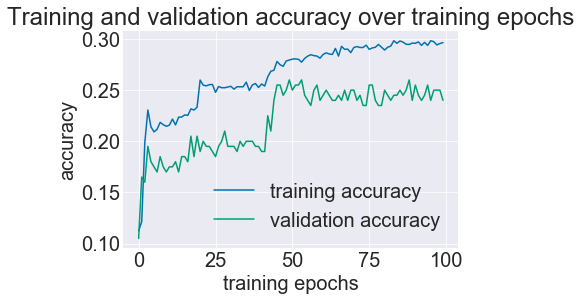

In [25]:
#training and validation accuracy over training epochs
plt.plot(hist.history['accuracy'], label = 'training accuracy')
plt.plot(hist.history['val_accuracy'], label = 'validation accuracy')
plt.legend()
plt.xlabel('training epochs')
plt.ylabel('accuracy')
plt.title('Training and validation accuracy over training epochs')
plt.show()

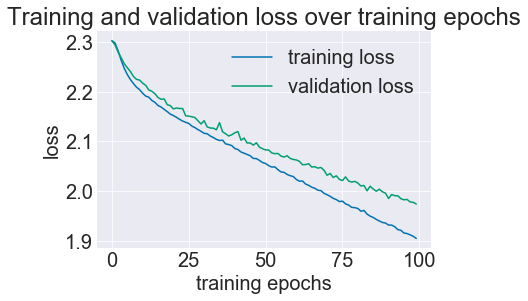

In [26]:
#training and validation loss over training epochs
plt.plot(hist.history['loss'], label = 'training loss')
plt.plot(hist.history['val_loss'], label = 'validation loss')
plt.legend()
plt.xlabel('training epochs')
plt.ylabel('loss')
plt.title('Training and validation loss over training epochs')
plt.show()

In [27]:
#print out the maximum validation accuracy
print('Maximum validation accuracy: ', np.max(hist.history['val_accuracy']))
#print out the minimum validation loss
print('Minimum validation loss: ', np.min(hist.history['val_loss']))

Maximum validation accuracy:  0.25999999046325684
Minimum validation loss:  1.9739207029342651


### Effects of architecture 4 on results: 
The best validation accuracy is 0.26 and the best validation loss is 1.97. This architecture does not perform  well in comparison to architecture 1 and architecture 2.

### Conclusion
Through these explorations, we have learnt that making the network architecture extremely complex might not always make it smarter. Overall, adding an additional sigmoid layer or adding an addtitional set of conv2D and maxpooling might be able to improve the performance of the network and avoid overfitting. 

### 6. Transfer learning: Can you apply Transfer learning to a binary or multi-class classification task with another dataset of your choice?